# 3 Features Construction

## 3.1 Sharpe Ratio and the Israelsen Trick
The Sharpe Ratio is a Performance Measure wich quotes the ratio between the sample mean and volatility of asset returns.
$$
SR = \frac{\hat{\mu}}{\hat{\sigma}}
$$
Here we use the approximation of zero interest-rates in the numerator (which is nearly certain for the majority of the training and validation set)

_Israelsen_ Trick. For $\mu<0$ Sharpe Ratio calculations can induce misleading rankings. Stocks with bad trend have also high volatility and this results in a SR with a small absolute value. They can easily overrated. In order to avoid this behaviour, Israelsen introduced the modified Sharpe Ratio:

$$
ISR = \frac{\hat{\mu}}{\hat{\sigma}^{sgn(\hat\mu)}}
$$


#### Imports and Loads Needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plot_args = {"figsize": (21,9),            
            "legend": True
}

In [2]:
daily_rets = (
    pd.read_csv("./data/config/20220831_baseline_portfolio_daily_returns.csv", 
    header=0, na_values="#N/A", index_col="Date", parse_dates=True)
)

#### Preliminar Checks

In [3]:
daily_rets.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-10-03,-0.002475,-0.010419,0.000885,-0.013060,-0.006757,-0.006139,-0.027333,0.013606,-0.006862,-0.005112,...,0.003057,0.016588,0.013250,-0.020014,-0.006456,0.001227,-0.008032,0.007014,0.010344,-0.005210
2006-10-04,0.024814,0.017548,0.016791,-0.009872,0.027483,0.016815,0.001081,0.000419,0.024932,0.002665,...,0.018796,0.007575,0.025064,0.005986,0.030325,0.000817,0.014756,0.029692,0.014819,0.007452
2006-10-05,-0.004238,-0.007297,0.015428,-0.016759,0.011123,-0.003713,0.009447,0.000000,0.030481,0.001898,...,0.005983,0.006941,0.013465,0.010151,-0.004906,-0.001632,0.008501,0.025632,0.000796,0.016793
2006-10-06,0.011854,-0.008152,-0.016691,-0.003452,-0.000786,0.018631,-0.010695,-0.004822,-0.001707,-0.005494,...,-0.011401,0.000574,-0.001748,-0.005544,0.008803,0.001635,-0.007542,-0.009372,-0.008489,-0.005112


In [6]:
daily_rets.index[0], daily_rets.index[-1]

(Timestamp('2006-10-02 00:00:00'), Timestamp('2022-08-31 00:00:00'))

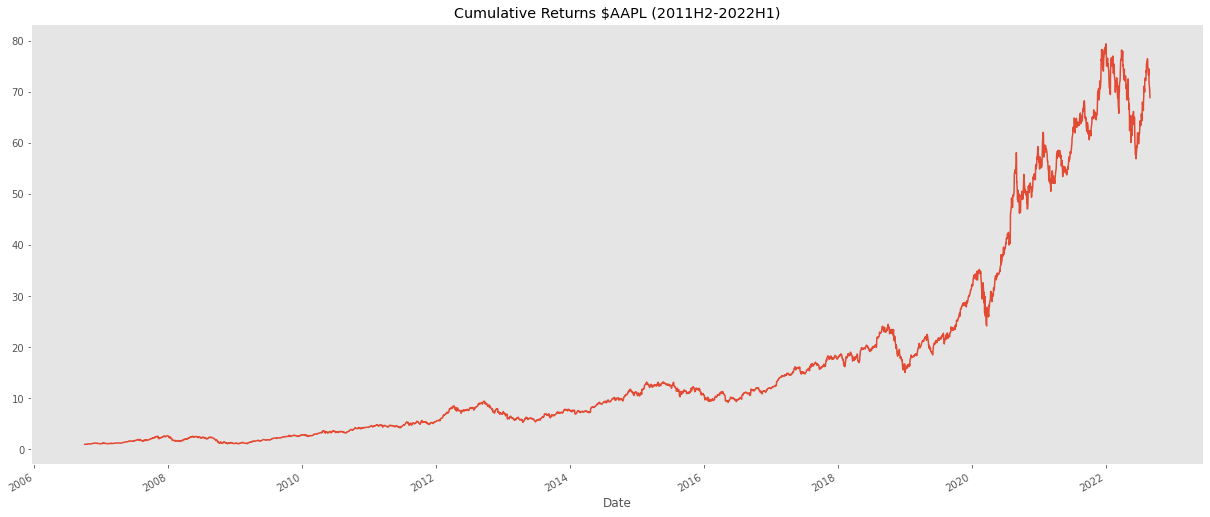

In [7]:
plt.style.use("ggplot")

aapl = daily_rets["AAPL"]
(1+aapl).cumprod().plot(figsize=(21,9), title="Cumulative Returns $AAPL (2011H2-2022H1)")
plt.grid();

### 3.1.1 (Israelsen) Sharpe Ratio Implementation and Rolling Window Calculation

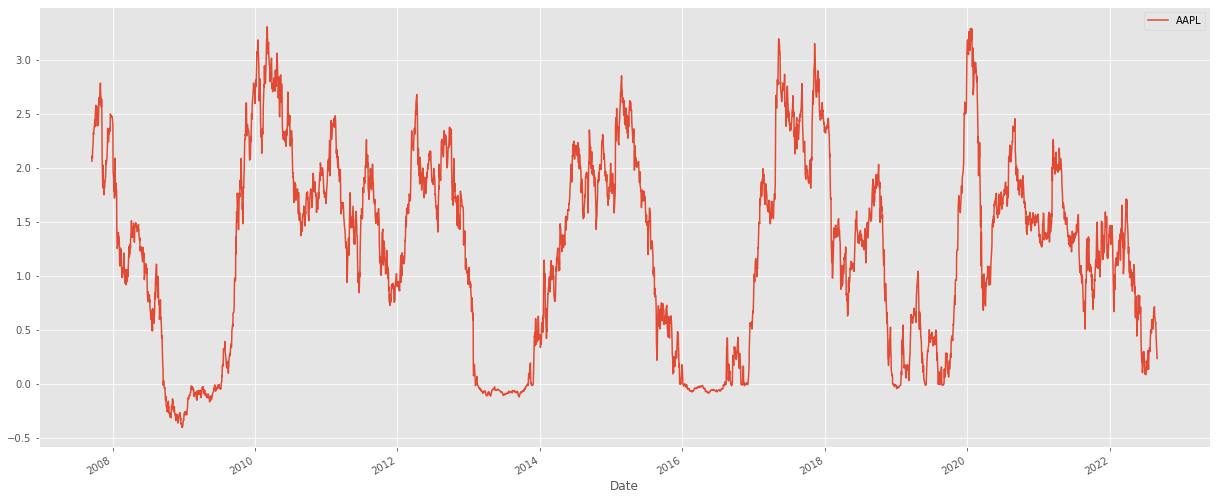

In [15]:
from modules import performance_measures_helper as pms

aapl_sharpe_ratio_approx = daily_rets["AAPL"].rolling(window="360D", min_periods=240).apply(pms.israelsen_sharpe_ratio)
aapl_sharpe_ratio_approx.plot(
    **plot_args
);

#### **A more accurate calculation**

In [11]:
aapl_sharpe_ratio_exact = [pms.israelsen_sharpe_ratio(aapl.loc[trading_date - pd.offsets.DateOffset(months=12):trading_date]) for trading_date in aapl.index]
aapl_sharpe_ratio_exact = pd.Series(data = aapl_sharpe_ratio_exact, index=aapl.index)

#### Comparing both approaches

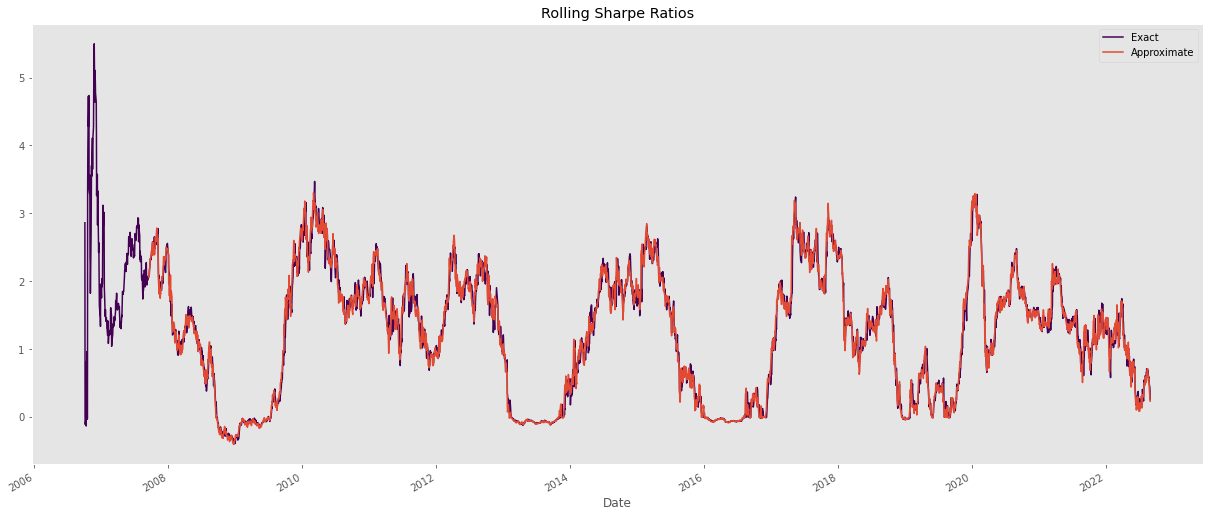

In [17]:
aapl_sharpe_ratio_exact.rename("Exact").plot(figsize=(21,9), title="Rolling Sharpe Ratios", legend=True, cmap="viridis")
aapl_sharpe_ratio_approx.rename("Approximate").plot(legend=True)
plt.grid();

Let's compare Rolling Sharpe for different portfolios, the single-stock `AAPL` versus equally-weighted `S&P500` (IVV ETF replica)

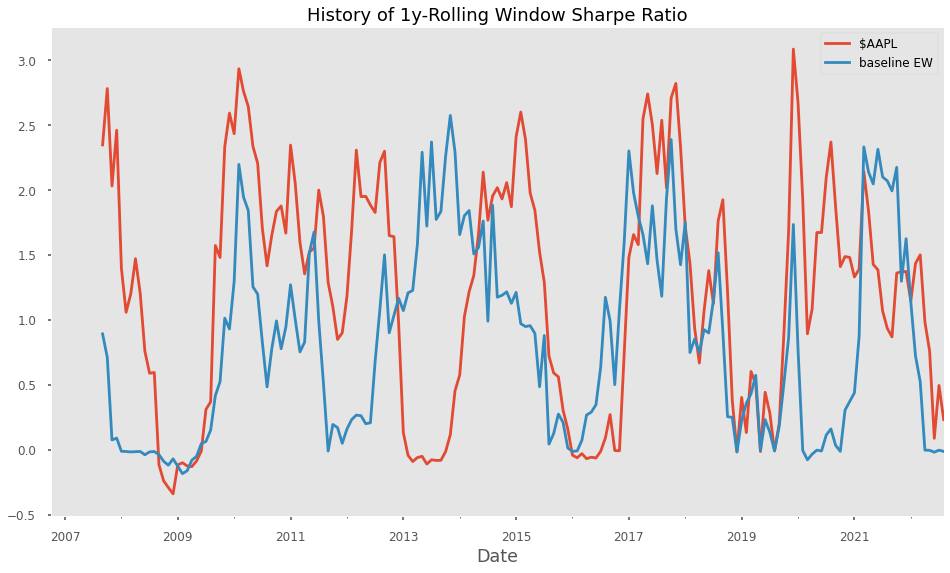

In [19]:
baseline_sharpe_ratio = daily_rets.mean(skipna=True, axis=1).rolling(window="360D", min_periods=240).apply(pms.israelsen_sharpe_ratio)

plt.style.use('seaborn-poster')

aapl_sharpe_ratio_approx.resample("BM").apply(lambda x: x[-1]).rename("$AAPL").plot(
    figsize=(16,9),     
    legend=True,
    fontsize=12    
)

baseline_sharpe_ratio.resample("BM").apply(lambda x: x[-1]).rename("baseline EW").plot(legend=True)
plt.title(label="History of 1y-Rolling Window Sharpe Ratio", fontsize=18)
plt.legend(fontsize=12)
plt.grid();


In [24]:
isr_daily = daily_rets.rolling(window="360D", min_periods=240).apply(
    pms.israelsen_sharpe_ratio
)

<AxesSubplot:xlabel='Date'>

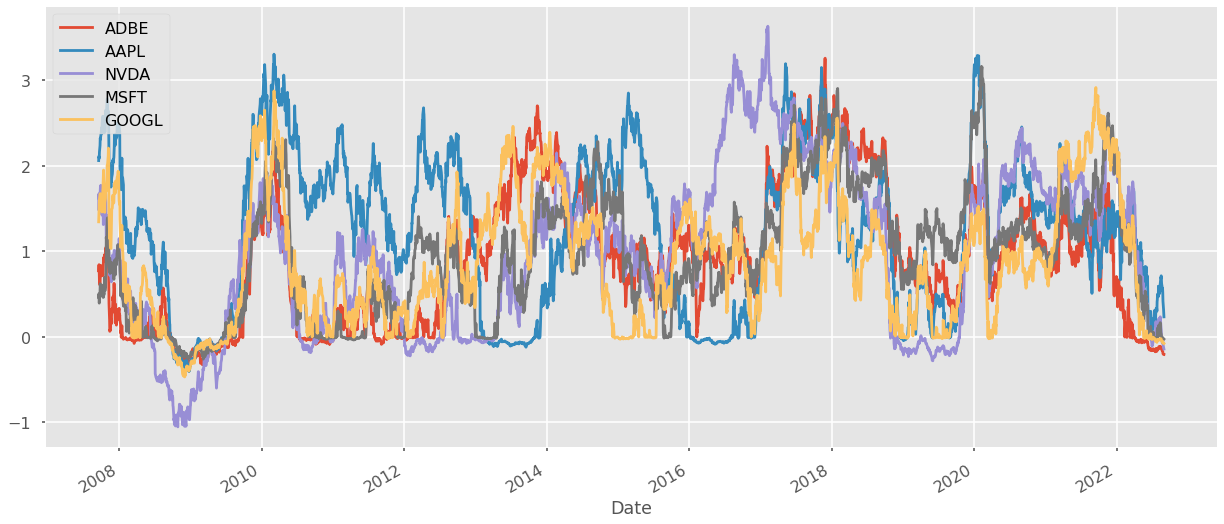

In [26]:
big_techs = ["ADBE", "AAPL", "NVDA", "MSFT", "GOOGL"]
isr_daily[big_techs].plot(**plot_args)    

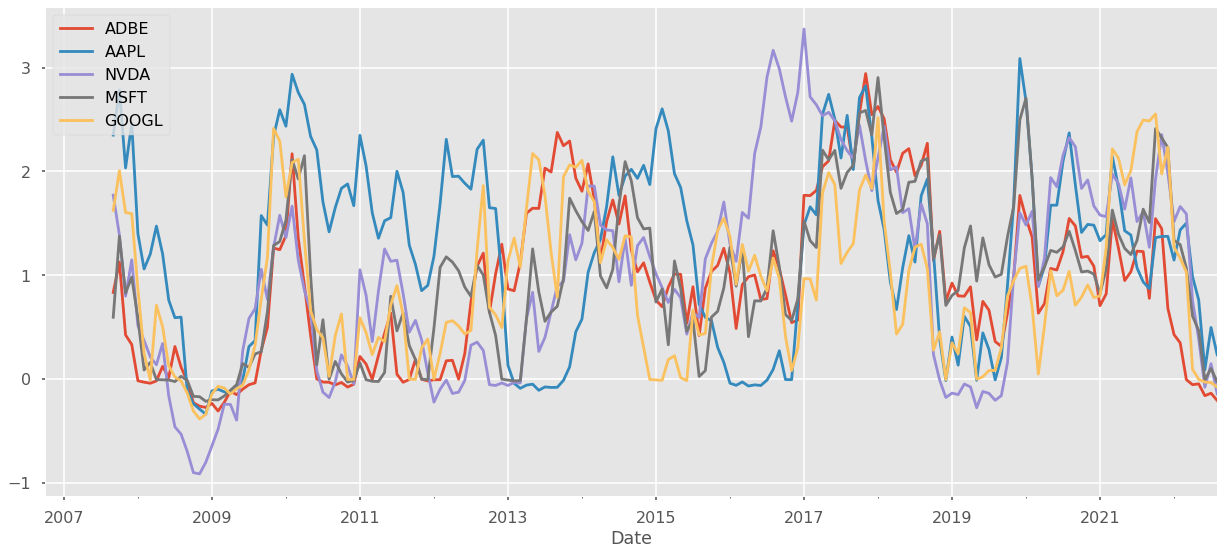

In [27]:
isr_monthly = isr_daily.resample("BM").apply(lambda x: x[-1]) # Simply Pick Up the Business End Of Month Value
isr_monthly[big_techs].plot(**plot_args);

### Appendix A: Implementing an Heuristical (non-ML) Screener based on SR ranks

In [30]:
isr_monthly.dropna(how="all", inplace=True)

In [31]:
isr_monthly.index[0], isr_monthly.index[-1]

(Timestamp('2007-09-28 00:00:00', freq='BM'),
 Timestamp('2022-08-31 00:00:00', freq='BM'))

1. Ranking Sharpe Ratios each End-Of-**Month** (EOM), binning into cat0 to cat19 stock classes:

In [32]:
isr_monthly_ranks = isr_monthly.rank(axis=1).apply(pms.scorer, axis=1) # The Higher the Rank the "Better" the Stock
isr_monthly_ranks.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-28,13,19,7,13,12,14,3,10,17,8,...,12,14,3,0,4,9,14,2,14,7
2007-10-31,11,19,9,13,14,10,9,14,15,9,...,14,17,2,0,3,8,10,1,12,7
2007-11-30,14,19,10,17,12,7,12,12,13,10,...,15,19,3,0,4,8,10,6,9,8
2007-12-31,12,19,10,15,12,9,18,11,14,13,...,15,19,1,0,3,12,8,10,11,8
2008-01-31,14,19,9,16,8,7,18,9,9,8,...,17,19,2,0,7,13,15,8,5,13


2. Cumulative Returns resample on a **Monthly** Basis

In [38]:
monthly_rets = daily_rets.resample("BM").apply(
    pms.multi_period_return    
)

In [39]:
monthly_rets.shape

(191, 469)

<AxesSubplot:xlabel='Date'>

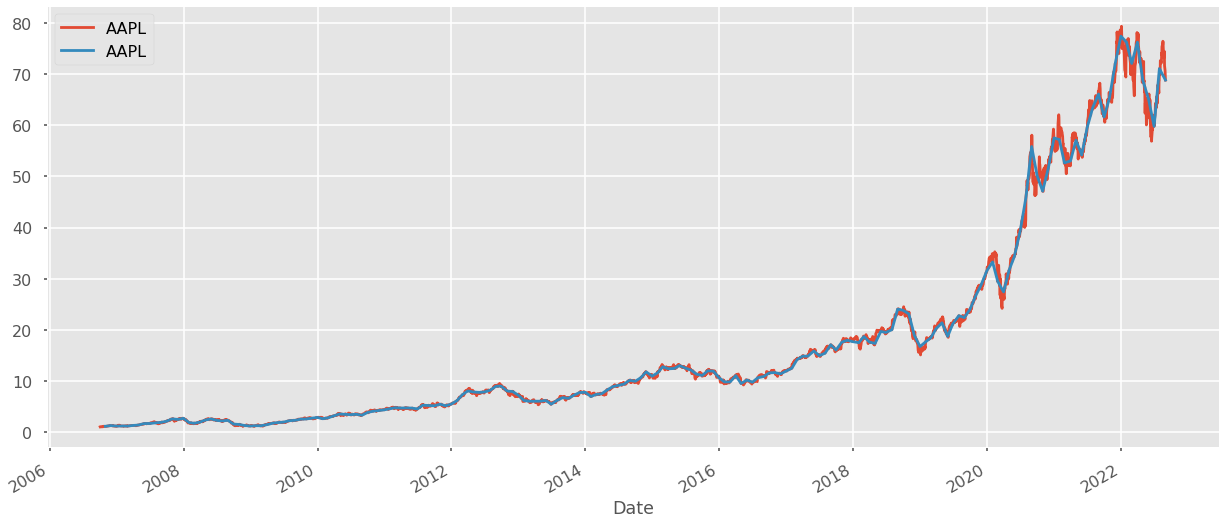

In [42]:
(1+daily_rets["AAPL"]).cumprod().plot(
    **plot_args
)

(1+monthly_rets["AAPL"]).cumprod().plot(
    **plot_args
);

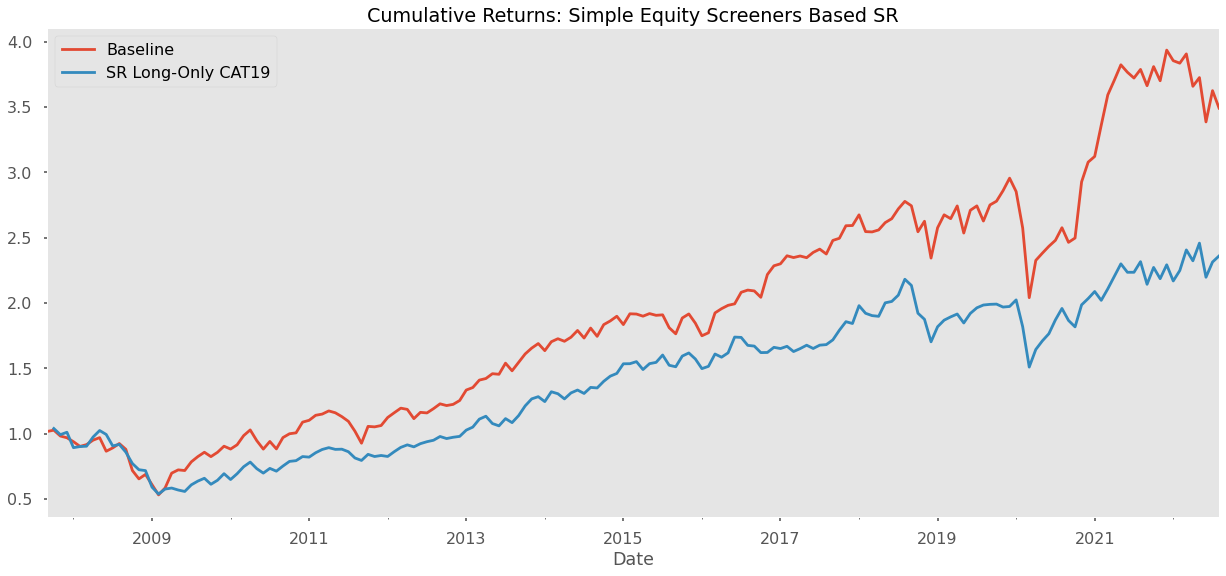

In [48]:
# Heuristic Trading Signals are available to implement during the period-after
mask_best = (isr_monthly_ranks.shift(1)==19)
#mask_worst = (isr_monthly_ranks.shift(1)==0)

# Baseline Strategy
(1+monthly_rets[isr_monthly.index[0]:].mean(axis=1,skipna=True)).rename("Baseline").cumprod().plot(**plot_args)

# Long Stocks with Best SR Previous Month
(1+monthly_rets[mask_best][isr_monthly.index[0]:].mean(axis=1, skipna=True)).rename("SR Long-Only CAT19").cumprod().plot(**plot_args)

plt.title("Cumulative Returns: Simple Equity Screeners Based SR")
plt.grid();


**Conclusion**: The (Israelsen) Sharpe Ratio is not a good feature if we want to challenge passive portfolios partially indexed to ETFs. 

2. **Daily**

In [51]:
isr_daily.dropna(how="all", inplace=True)

In [53]:
isr_daily.rank(axis=1).apply(
    pms.scorer,    
)

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-17,13,19,8,11,13,13,1,8,17,8,...,13,16,11,0,6,10,15,0,13,6
2007-09-18,13,19,7,12,12,13,0,7,17,8,...,13,15,12,0,5,10,16,1,13,6
2007-09-19,13,19,7,11,12,13,0,8,17,8,...,14,15,12,0,5,10,16,1,14,6
2007-09-20,13,19,7,12,11,14,0,9,17,8,...,14,15,11,0,5,10,15,1,13,6
2007-09-21,12,19,6,12,10,13,1,9,17,8,...,13,15,10,0,4,9,15,2,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-25,2,14,18,5,0,10,19,17,1,16,...,11,11,18,13,16,7,12,6,8,13
2022-08-26,2,14,17,5,0,10,19,17,1,16,...,11,11,18,13,17,8,12,7,8,14
2022-08-29,2,13,17,5,0,9,19,17,2,16,...,12,10,18,13,17,7,12,6,7,13


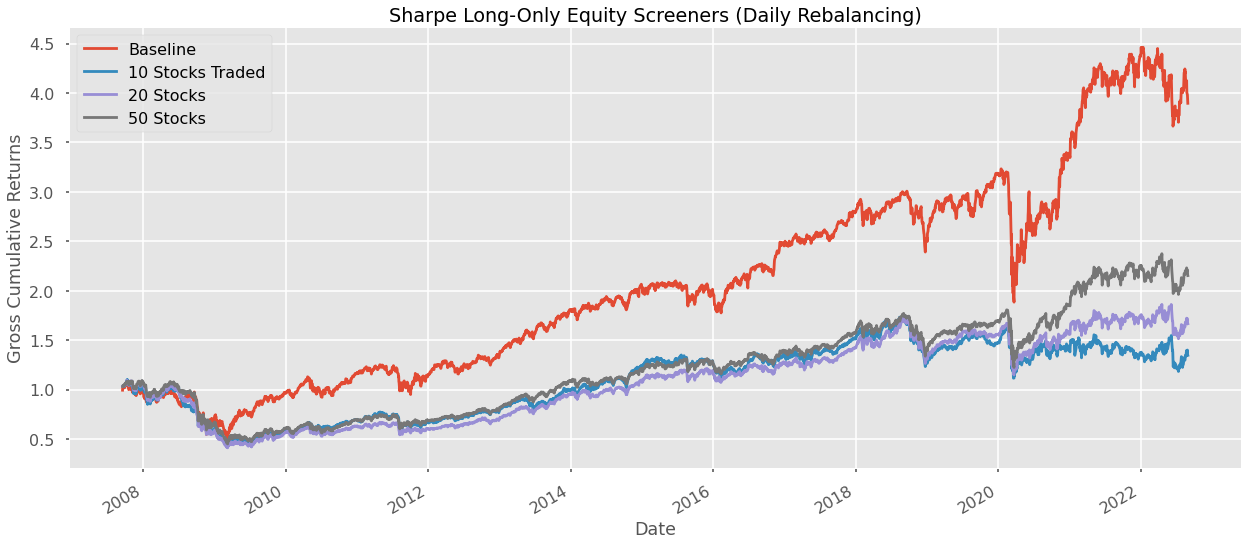

In [55]:
# Baseline Strategy
(1+daily_rets[isr_daily.index[0]:].mean(axis=1,skipna=True)).rename("Baseline").cumprod().plot(**plot_args)

# Long Stocks with Best SR Previous Date
labels = ["10 Stocks Traded", "20 Stocks", "50 Stocks"]
bins = [50, 20, 10]
for bin, label in zip(bins,labels):
    mask = (isr_daily.rank(axis=1).apply(pms.scorer, bins=bin, axis=1).shift(1)==bin-1)
    (1+daily_rets[mask].mean(axis=1, skipna=True)).rename(label).cumprod().plot(**plot_args)

plt.title("Sharpe Long-Only Equity Screeners (Daily Rebalancing)")
plt.ylabel("Gross Cumulative Returns");

3. **Weekly**

Resampling Israelsen-Sharpe Ratio each end-of-week:

In [56]:
isr_weekly = isr_daily.resample("W-FRI").apply(lambda x: x[-1])

In [585]:
daily_rets.iloc[-4:]

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-29,0.022805,NaN,-0.003634,0.013558,0.032793,-0.041669,0.002473,0.002772,-0.013773,NaN,...,-0.005227,NaN,0.022783,NaN,-0.001385,-0.003520,0.038287,0.020007,NaN,0.001536
2022-08-01,-0.004996,NaN,0.041575,0.012241,-0.006153,-0.022925,0.000000,-0.003788,0.006248,NaN,...,-0.004978,NaN,-0.009019,NaN,0.001632,-0.005707,0.002069,-0.011366,NaN,-0.015393
2022-08-02,-0.016113,NaN,-0.015406,-0.004949,-0.009287,0.001212,-0.021380,0.005927,-0.008035,NaN,...,-0.011395,NaN,0.045724,NaN,-0.004970,0.039176,-0.097955,-0.015390,NaN,-0.005063
2022-08-03,0.024985,NaN,0.040541,0.001282,0.038248,0.005770,-0.026679,0.026666,0.008929,NaN,...,0.009278,NaN,0.020342,NaN,-0.018996,0.013589,0.009557,0.016196,NaN,0.007437


In [57]:
weekly_returns = daily_rets.resample("W-FRI").apply(pms.multi_period_return)

<AxesSubplot:xlabel='Date'>

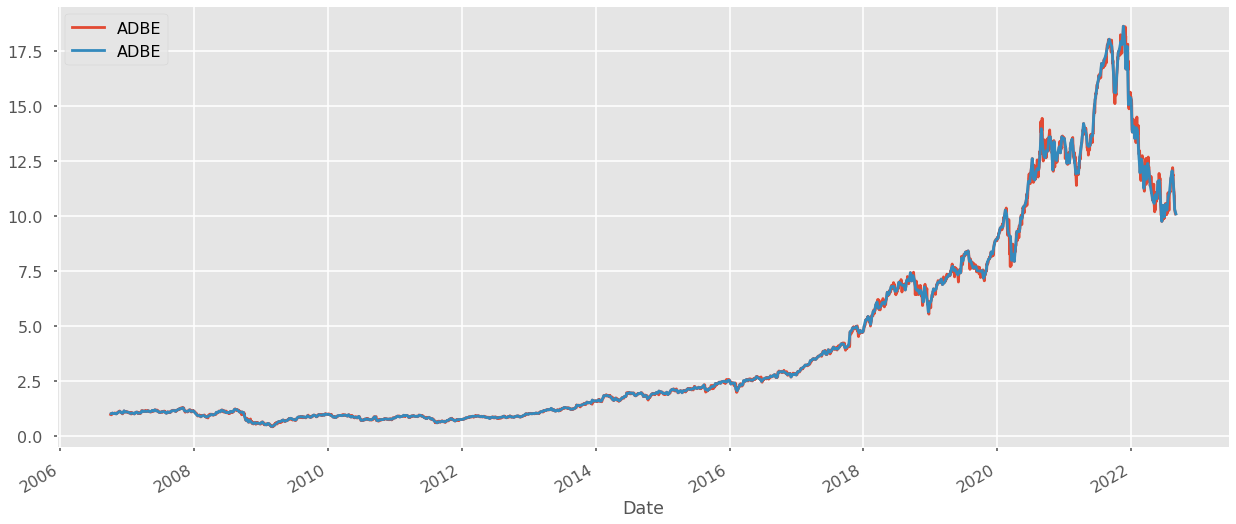

In [61]:
(1+daily_rets["ADBE"]).cumprod().plot(figsize=(21,9), legend=True)
(1+weekly_returns["ADBE"]).cumprod().plot(legend=True)

In [62]:
isr_weekly

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-21,0.936074,2.159896,0.275863,0.883776,0.650003,1.045902,-0.025734,0.727662,1.512986,0.436771,...,0.970845,1.192436,0.604618,-0.119391,-0.001284,0.585140,1.129688,-0.022748,0.948835,0.180971
2007-09-28,0.934628,2.349040,0.270601,0.864342,0.833943,1.012076,-0.017460,0.584541,1.610474,0.371573,...,0.830786,1.041545,-0.022213,-0.130790,-0.014663,0.537804,1.116586,-0.030958,0.971041,0.253019
2007-10-05,0.897213,2.504048,0.261197,1.117539,0.818072,0.939052,-0.018128,0.931028,1.410242,0.479380,...,0.955374,0.991091,-0.030842,-0.115109,-0.034166,0.565575,1.157343,-0.024284,1.155625,0.355661
2007-10-12,0.749171,2.570104,0.194231,0.804120,0.925903,0.829460,0.004727,0.948828,1.528014,0.435485,...,0.781890,1.096964,-0.046507,-0.188979,-0.057400,0.553362,0.845322,-0.052519,0.919431,0.289008
2007-10-19,0.647079,2.392162,-0.001285,0.573657,0.939192,0.788482,-0.009613,0.766735,1.048820,0.121112,...,0.561687,1.012860,-0.067368,-0.252530,-0.043150,0.334349,0.469889,-0.064865,0.569517,-0.004991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-05,-0.032933,0.591916,0.956253,-0.017435,-0.114209,0.328837,1.283425,0.720001,-0.138041,0.455502,...,0.265538,-0.017552,1.271098,0.611991,0.685289,-0.025545,0.372957,-0.015169,-0.013928,0.372921
2022-08-12,-0.041842,0.620744,1.152664,-0.018377,-0.111676,0.450274,1.416725,0.901170,-0.105460,0.520792,...,0.268009,0.256028,1.174366,0.559593,0.872844,-0.015692,0.458104,0.065648,0.102554,0.510226
2022-08-19,-0.051275,0.623021,1.307630,-0.021090,-0.145386,0.258071,1.573644,1.077356,-0.150037,0.845067,...,0.354890,0.219687,1.064216,0.525150,1.009736,-0.011523,0.386965,0.009991,0.007191,0.534782


In [63]:
isr_rank_weekly = isr_weekly.rank(axis=1).apply(pms.scorer, axis=1)
isr_rank_weekly

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-21,13,19,7,12,11,14,2,11,17,8,...,13,15,10,0,4,10,15,2,13,6
2007-09-28,13,19,7,13,12,14,3,10,17,8,...,12,14,3,0,4,9,14,2,14,7
2007-10-05,13,19,6,14,12,13,2,13,16,8,...,13,13,2,0,1,9,15,2,15,7
2007-10-12,12,19,7,12,14,12,5,14,17,9,...,12,14,1,0,1,10,13,1,13,7
2007-10-19,13,19,7,12,15,14,6,14,15,8,...,12,15,2,0,3,10,11,2,12,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-05,6,16,18,7,2,13,19,17,1,15,...,12,7,19,16,17,7,14,8,8,14
2022-08-12,4,15,18,6,1,13,19,17,2,14,...,11,11,18,14,17,6,13,8,9,13
2022-08-19,4,14,18,6,1,11,19,17,1,16,...,12,11,17,13,17,7,12,9,8,14


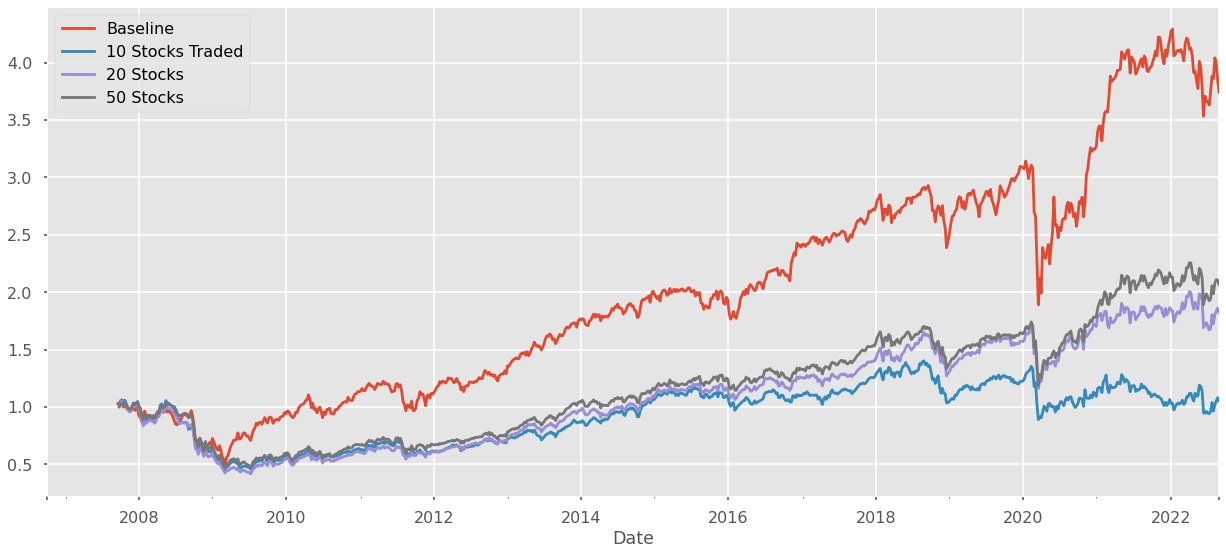

In [64]:
# Baseline Strategy
(1+weekly_returns[isr_rank_weekly.index[0]:].mean(axis=1,skipna=True)).rename("Baseline").cumprod().plot(**plot_args)

# Long Stocks with Best SR Previous Date
labels = ["10 Stocks Traded", "20 Stocks", "50 Stocks"]
bins = [50, 20, 10]
for bin, label in zip(bins,labels):
    mask = (isr_weekly.rank(axis=1).apply(pms.scorer, bins=bin, axis=1).shift(1)==bin-1)
    (1+weekly_returns[mask].mean(axis=1, skipna=True)).rename(label).cumprod().plot(**plot_args)

### 3.1.2 ISR for Target Labelling

* Daily

In [76]:
isr_score = isr_daily.rank(axis=1).apply(
    pms.scorer, axis=1
).shift(-1)

In [81]:
# "Limitless"-Style Perfect Trading
mask = isr_score.shift(1)==19

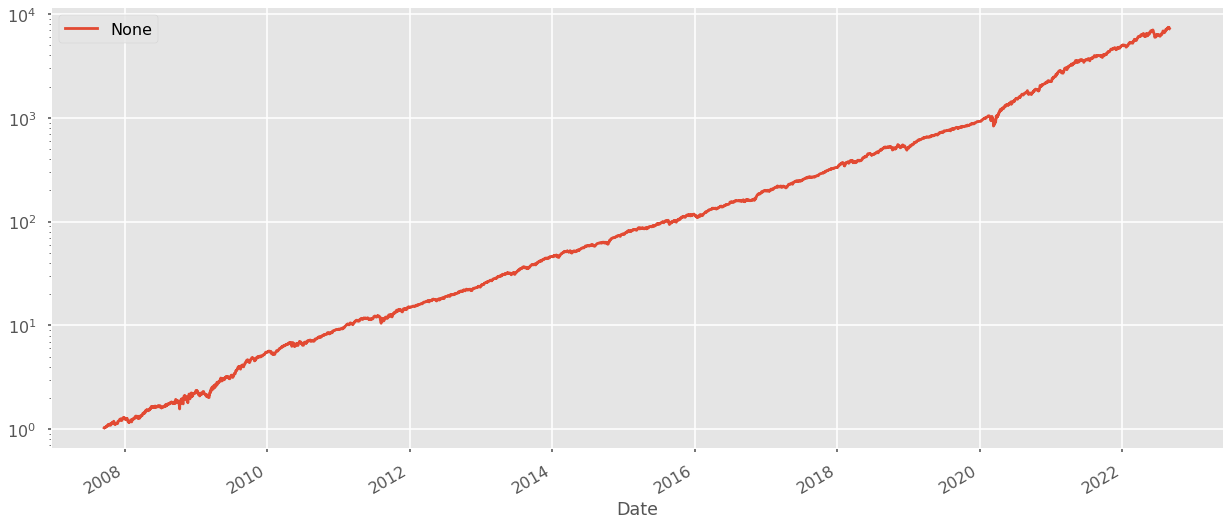

In [82]:
(1+daily_rets[mask][isr_score.index[0]:].mean(axis=1)).cumprod().plot(**plot_args)
plt.semilogy();

It could be very useful (if not so _perfect_ as labelling with returns realized over the next period) even taken into account the total wealth.

Here we are playing with the fact of a better explanation of SR (or any other PM) over one-period ahead.

* Monthly

In [92]:
isr_score_monthly = isr_monthly.rank(axis=1).apply(
    pms.scorer,
    axis=1
).shift(-1)

In [93]:
isr_score_monthly.apply(pd.value_counts, axis=1)

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
Date,,,,,,,,,,,,,,,,,,,,
2007-09-28,24.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0
2007-10-31,24.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0
2007-11-30,24.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0
2007-12-31,24.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0
2008-01-31,24.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,24.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0
2022-05-31,24.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0
2022-06-30,24.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0,23.0,23.0,24.0,23.0,24.0


* Masking and Trading

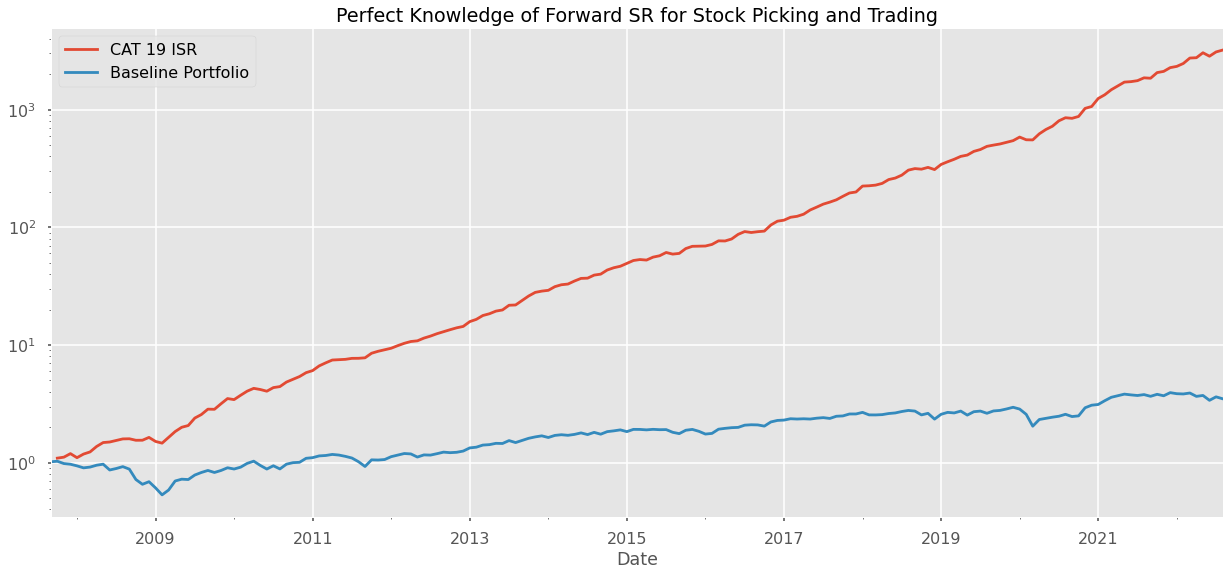

In [97]:
mask_monthly = isr_score_monthly.shift(1)==19

(1+monthly_rets[mask_monthly][isr_score_monthly.index[0]:].mean(axis=1)).cumprod().rename(
    "CAT 19 ISR"
).plot(**plot_args)

(1+monthly_rets[isr_score_monthly.index[0]:].mean(axis=1)).cumprod().rename(
    "Baseline Portfolio"    
).plot(**plot_args, title="Perfect Knowledge of Forward SR for Stock Picking and Trading")
plt.semilogy();

A Good Shape for substituting one-period Returns Ahead

In [115]:
isr_rank_daily = isr_daily.rank(axis=1).apply(
    pms.scorer,
    axis=1
)

In [116]:
isr_rank_daily.head()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-17,14,19,8,12,13,14,2,10,17,8,...,13,16,11,0,6,10,15,1,13,6
2007-09-18,13,19,7,12,12,14,1,10,17,8,...,13,15,12,0,5,10,15,1,13,6
2007-09-19,13,19,7,12,12,13,1,11,17,8,...,14,15,12,0,5,10,15,1,14,6
2007-09-20,13,19,7,12,11,14,1,11,17,8,...,14,15,11,0,5,11,15,2,13,6
2007-09-21,13,19,7,12,11,14,2,11,17,8,...,13,15,10,0,4,10,15,2,13,6


In [117]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
daily_rets          DataFrame                       A     <...>[4007 rows x 469 columns]
isr_daily           DataFrame                       A     <...>[3767 rows x 469 columns]
isr_monthly         DataFrame                       A     <...>n[180 rows x 469 columns]
isr_rank_daily      DataFrame                 A  AAPL  ABC<...>[3767 rows x 469 columns]
isr_rank_monthly    DataFrame                 A  AAPL  ABC<...>n[180 rows x 469 columns]
isr_rank_weekly     DataFrame                 A  AAPL  ABC<...>n[781 rows x 469 columns]
isr_score           DataFrame                   A  AAPL   <...>[3767 rows x 469 columns]
isr_score_monthly   DataFrame                   A  AAPL   <...>n[180 rows x 469 columns]
isr_weekly          DataFrame                       A     <...>n[781 rows x 469 columns]
mask                DataFrame                    A   AAPL <...>[3767 rows x 469 columns]
mask_best           Data

### 3.1.3 Faster Rolling (Israelsen) Sharpe Ratios

* UltraFast and Fast ISR (3M, 6M window):

In [118]:
isr_daily_win3m = daily_rets.rolling(window=63).apply(pms.israelsen_sharpe_ratio)
isr_daily_win6m = daily_rets.rolling(window=126).apply(pms.israelsen_sharpe_ratio)

In [125]:
# Downsampling
# a) Weekly (on Fri)
isr_weekly_win3m = isr_daily_win3m.resample("W-FRI").apply(lambda x: x[-1])
isr_weekly_win6m = isr_daily_win6m.resample("W-FRI").apply(lambda x: x[-1])
# b) Monthly (Business EOM)
isr_monthly_win3m = isr_daily_win3m.resample("BM").apply(lambda x: x[-1])
isr_monthly_win6m = isr_daily_win6m.resample("BM").apply(lambda x: x[-1])

In [127]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
daily_rets          DataFrame                       A     <...>[4007 rows x 469 columns]
isr_daily           DataFrame                       A     <...>[3767 rows x 469 columns]
isr_daily_win3m     DataFrame                       A     <...>[4007 rows x 469 columns]
isr_daily_win6m     DataFrame                       A     <...>[4007 rows x 469 columns]
isr_monthly         DataFrame                       A     <...>n[180 rows x 469 columns]
isr_monthly_win3m   DataFrame                       A     <...>n[191 rows x 469 columns]
isr_monthly_win6m   DataFrame                       A     <...>n[191 rows x 469 columns]
isr_rank_daily      DataFrame                 A  AAPL  ABC<...>[3767 rows x 469 columns]
isr_rank_monthly    DataFrame                 A  AAPL  ABC<...>n[180 rows x 469 columns]
isr_rank_weekly     DataFrame                 A  AAPL  ABC<...>n[781 rows x 469 columns]
isr_score           Data

In [129]:
isr_monthly_win3m.dropna(how="all", inplace=True)
isr_monthly_win6m.dropna(how="all", inplace=True)

In [140]:
mask_best_fastest = isr_monthly_win3m.rank(axis=1).apply(pms.scorer, axis=1).shift(1) == 19
mask_best_fast = isr_monthly_win6m.rank(axis=1).apply(pms.scorer, axis=1).shift(1) == 19
mask_best = isr_monthly.rank(axis=1).apply(pms.scorer, axis=1).shift(1) == 19


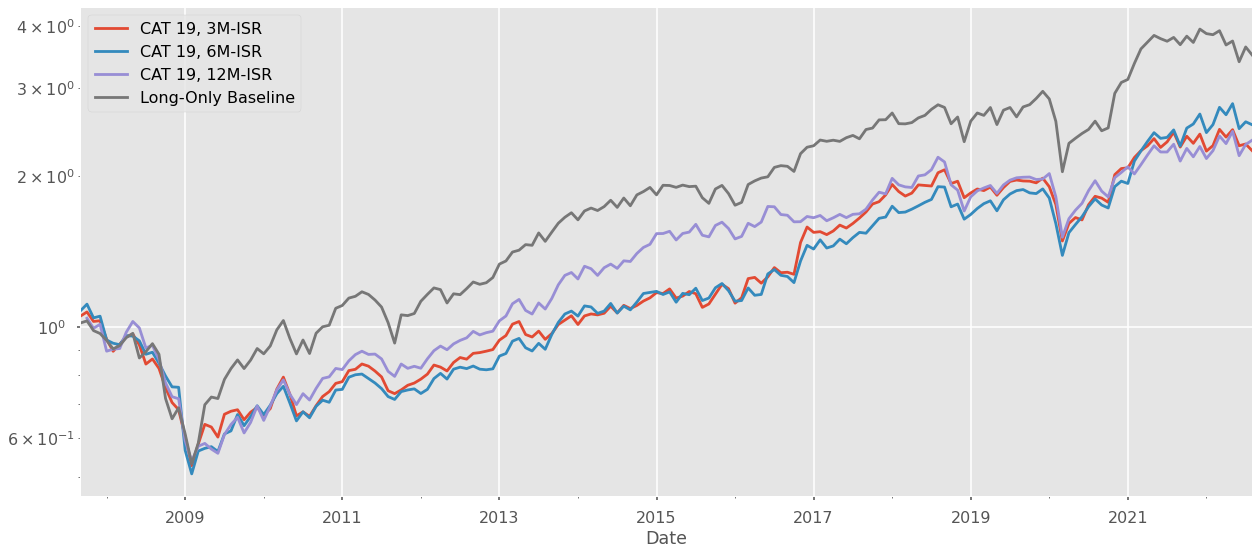

In [144]:
inception_cut = isr_monthly.index[0]

(1+monthly_rets[mask_best_fastest][inception_cut:].mean(axis=1)).cumprod().rename(
    "CAT 19, 3M-ISR"
).plot(**plot_args)

(1+monthly_rets[mask_best_fast][inception_cut:].mean(axis=1)).cumprod().rename(
    "CAT 19, 6M-ISR"
).plot(**plot_args)

(1+monthly_rets[mask_best][inception_cut:].mean(axis=1)).cumprod().rename(
    "CAT 19, 12M-ISR"
).plot(**plot_args)

(1+monthly_rets[inception_cut:].mean(axis=1)).cumprod().rename(
    "Long-Only Baseline"
).plot(**plot_args)

plt.semilogy();

### Appendix B: Dumping Multi-Sampled and Multi-Window ISR-type Features

In [152]:
isharpe_data = dict()
isharpe_data["daily"] = dict()

In [153]:
isharpe_data["daily"]["3m"] = isr_daily_win3m
isharpe_data["daily"]["6m"] = isr_daily_win6m
isharpe_data["daily"]["12m"] = isr_daily

isharpe_data["weekly"] = dict()
isharpe_data["weekly"]["3m"] = isr_weekly_win3m
isharpe_data["weekly"]["6m"] = isr_weekly_win6m
isharpe_data["weekly"]["12m"] = isr_weekly

isharpe_data["monthly"] = dict()
isharpe_data["monthly"]["3m"] = isr_monthly_win3m
isharpe_data["monthly"]["6m"] = isr_monthly_win6m
isharpe_data["monthly"]["12m"] = isr_monthly

In [159]:
with open("data/config/20220831_all_isharpes_data.pkl","wb") as f:
    pickle.dump(isharpe_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [160]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
daily_rets          DataFrame                       A     <...>[4007 rows x 469 columns]
isr_daily           DataFrame                       A     <...>[3767 rows x 469 columns]
isr_daily_win3m     DataFrame                       A     <...>[4007 rows x 469 columns]
isr_daily_win6m     DataFrame                       A     <...>[4007 rows x 469 columns]
isr_monthly         DataFrame                       A     <...>n[180 rows x 469 columns]
isr_monthly_win3m   DataFrame                       A     <...>n[188 rows x 469 columns]
isr_monthly_win6m   DataFrame                       A     <...>n[185 rows x 469 columns]
isr_rank_daily      DataFrame                 A  AAPL  ABC<...>[3767 rows x 469 columns]
isr_rank_monthly    DataFrame                 A  AAPL  ABC<...>n[180 rows x 469 columns]
isr_rank_weekly     DataFrame                 A  AAPL  ABC<...>n[781 rows x 469 columns]
isr_score           Data

In [161]:
with open("data/config/20220831_returns_scores.pkl","rb") as handle:
    ret_scores_data = pickle.load(handle)

ret_scores_data.keys()

dict_keys(['raw_returns', 'sma_vols', 'ewma_vols', 'score'])

In [162]:
ret_scores_data["score"].keys()

dict_keys(['daily', 'weekly', 'monthly'])

In [166]:
isr_score_weekly = isr_score.resample("W-FRI").apply(lambda x: x[-1])

In [169]:
isr_score_monthly.iloc[-1]

A      NaN
AAPL   NaN
ABC    NaN
ABT    NaN
ADBE   NaN
        ..
UGI    NaN
WAFD   NaN
FORR   NaN
FRT    NaN
WABC   NaN
Name: 2022-08-31 00:00:00, Length: 469, dtype: float64

In [171]:
isr_score = dict()
isr_score["daily"]= dict()
isr_score["daily"]["12m"] = isr_score

isr_score["weekly"]= dict()
isr_score["weekly"]["12m"] = isr_score_weekly

isr_score["monthly"]= dict()
isr_score["monthly"]["12m"] = isr_score_monthly

In [182]:
# Recalculating Scores Based on Fast and Fastest ISR
isr_score["daily"]["3m"] = isr_daily_win3m.dropna(how="all").rank(axis=1).apply(
    pms.scorer,
    axis=1
).shift(-1)
isr_score["daily"]["6m"] = isr_daily_win6m.dropna(how="all").rank(axis=1).apply(
    pms.scorer,
    axis=1
).shift(-1)

isr_score["weekly"]["3m"] = isr_weekly_win3m.dropna(how="all").rank(axis=1).apply(
    pms.scorer,
    axis=1
).shift(-1)
isr_score["weekly"]["6m"] = isr_weekly_win6m.dropna(how="all").rank(axis=1).apply(
    pms.scorer,
    axis=1
).shift(-1)

isr_score["monthly"]["3m"] = isr_monthly_win3m.dropna(how="all").apply(
    pms.scorer,
    axis=1
).shift(-1)
isr_score["monthly"]["6m"] = isr_monthly_win6m.dropna(how="all").apply(
    pms.scorer,
    axis=1
).shift(-1)

In [183]:
with open("data/config/20220831_isharpe_scores.pkl","wb") as file:
    pickle.dump(isr_score, file, protocol=pickle.HIGHEST_PROTOCOL)